In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103

In [ ]:
from torchtext import data
from torchtext import datasets

In [ ]:
import torch
from torch import nn
import torch.optim as optim

In [ ]:
from pyvi.ViTokenizer import tokenize
import re, os, string
import pandas as pd

def clean_text(text):
    text = re.sub('<.*?>', '', text).strip()
    text = re.sub('(\s)+', r'\1', text)
    return text

def normalize_text(text):
    listpunctuation = string.punctuation.replace('_', '')
    for i in listpunctuation:
        text = text.replace(i, ' ')
    return text.lower()

# list stopwords
filename = '/content/stopwords.txt'
data = pd.read_csv(filename, sep="\t", encoding='utf-8')
list_stopwords = data['stopwords']

def remove_stopword(text):
    pre_text = []
    words = text.split()
    for word in words:
        if word not in list_stopwords:
            pre_text.append(word)
    text2 = ' '.join(pre_text)

    return text2

def sentence_segment(text):
    sents = re.split("([.?!])?[\n]+|[.?!] ", text)
    return sents


def word_segment(sent):
    sent = tokenize(sent.decode('utf-8'))
    return sent



f_w = open('./datatrain.txt', 'w')
for i, sub_dir in enumerate(os.listdir(path_to_corpus)):
    path_to_subdir = path_to_corpus + '/' + sub_dir
    for j, file_name in enumerate(os.listdir(path_to_subdir)):
        with open(path_to_subdir + '/' + file_name) as f_r:
            contents = f_r.read().strip().split('</doc>')
            for content in contents:
                if (len(content) < 5):
                    continue
                content = clean_text(content)
                sents = sentence_segment(content)
                for sent in sents:
                    if(sent != None):
                        sent = word_segment(sent)
                        sent = remove_stopword(normalize_text(sent))
                        if(len(sent.split()) > 1):
                            f_w.write(sent.encode('utf-8') + '\n')
            print("Done ", i + 1, ':', j + 1)

f_w.close()

In [ ]:
with open('/content/drive/MyDrive/Word2Vec_Vi/datatrain.txt') as f:
    text = f.read()

In [ ]:
print(text[5154000:5154139])

giá đồng ruble từng sụt_giảm ở mức được cho là mạnh nhất trong vòng 16 năm qua việc đông ruble mất_giá thê_thảm trong một thời_gian ngắn đã


In [ ]:
words = []
for word in text.split():
    words.append(word)

In [ ]:
words[:30]

In [ ]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 5154139
Unique words: 191067


In [ ]:

from collections import Counter

def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [ ]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[482, 509, 4160, 4160, 13288, 0, 6096, 4474, 1994, 1, 2556, 4, 971, 90, 30199, 1565, 21, 2303, 1432, 184, 2146, 34, 1201, 19, 41779, 26850, 33, 29, 16035, 1310]


In [ ]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[4160, 13288, 6096, 4474, 1994, 30199, 2303, 1432, 41779, 26850, 16035, 51, 267, 568, 2928, 1994, 6, 488, 22234, 847, 53421, 1389, 5758, 34749, 6096, 4474, 2928, 134, 79968, 5950]


In [ ]:
# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

In [ ]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [ ]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab,n_embed)
        self.out_embed = nn.Embedding(n_vocab,n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1,1)
        self.out_embed.weight.data.uniform_(-1,1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        input_vector = self.in_embed(input_words)
        return input_vector
    
    def forward_output(self, output_words):
        # return output vector embeddings
        output_vector = self.out_embed(output_words)

        return output_vector
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        # output embedding layer
        noise_vector = self.out_embed(noise_words).view(batch_size,n_samples,self.n_embed)        
        return noise_vector

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 8

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point 

Epoch: 1/8
Loss:  7.630048751831055
Epoch: 2/8
Loss:  5.9619221687316895
Epoch: 2/8
Loss:  4.248305797576904
Epoch: 3/8
Loss:  3.5241239070892334
Epoch: 3/8
Loss:  3.0590405464172363
Epoch: 4/8
Loss:  2.442554235458374
Epoch: 4/8
Loss:  2.299503803253174
Epoch: 5/8
Loss:  2.385725975036621
Epoch: 5/8
Loss:  2.064725637435913
Epoch: 6/8
Loss:  1.7082780599594116
Epoch: 6/8
Loss:  1.9105454683303833
Epoch: 7/8
Loss:  1.4693750143051147
Epoch: 7/8
Loss:  1.82228684425354
Epoch: 8/8
Loss:  1.7632092237472534


In [ ]:
model

SkipGramNeg(
  (in_embed): Embedding(191067, 300)
  (out_embed): Embedding(191067, 300)
)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


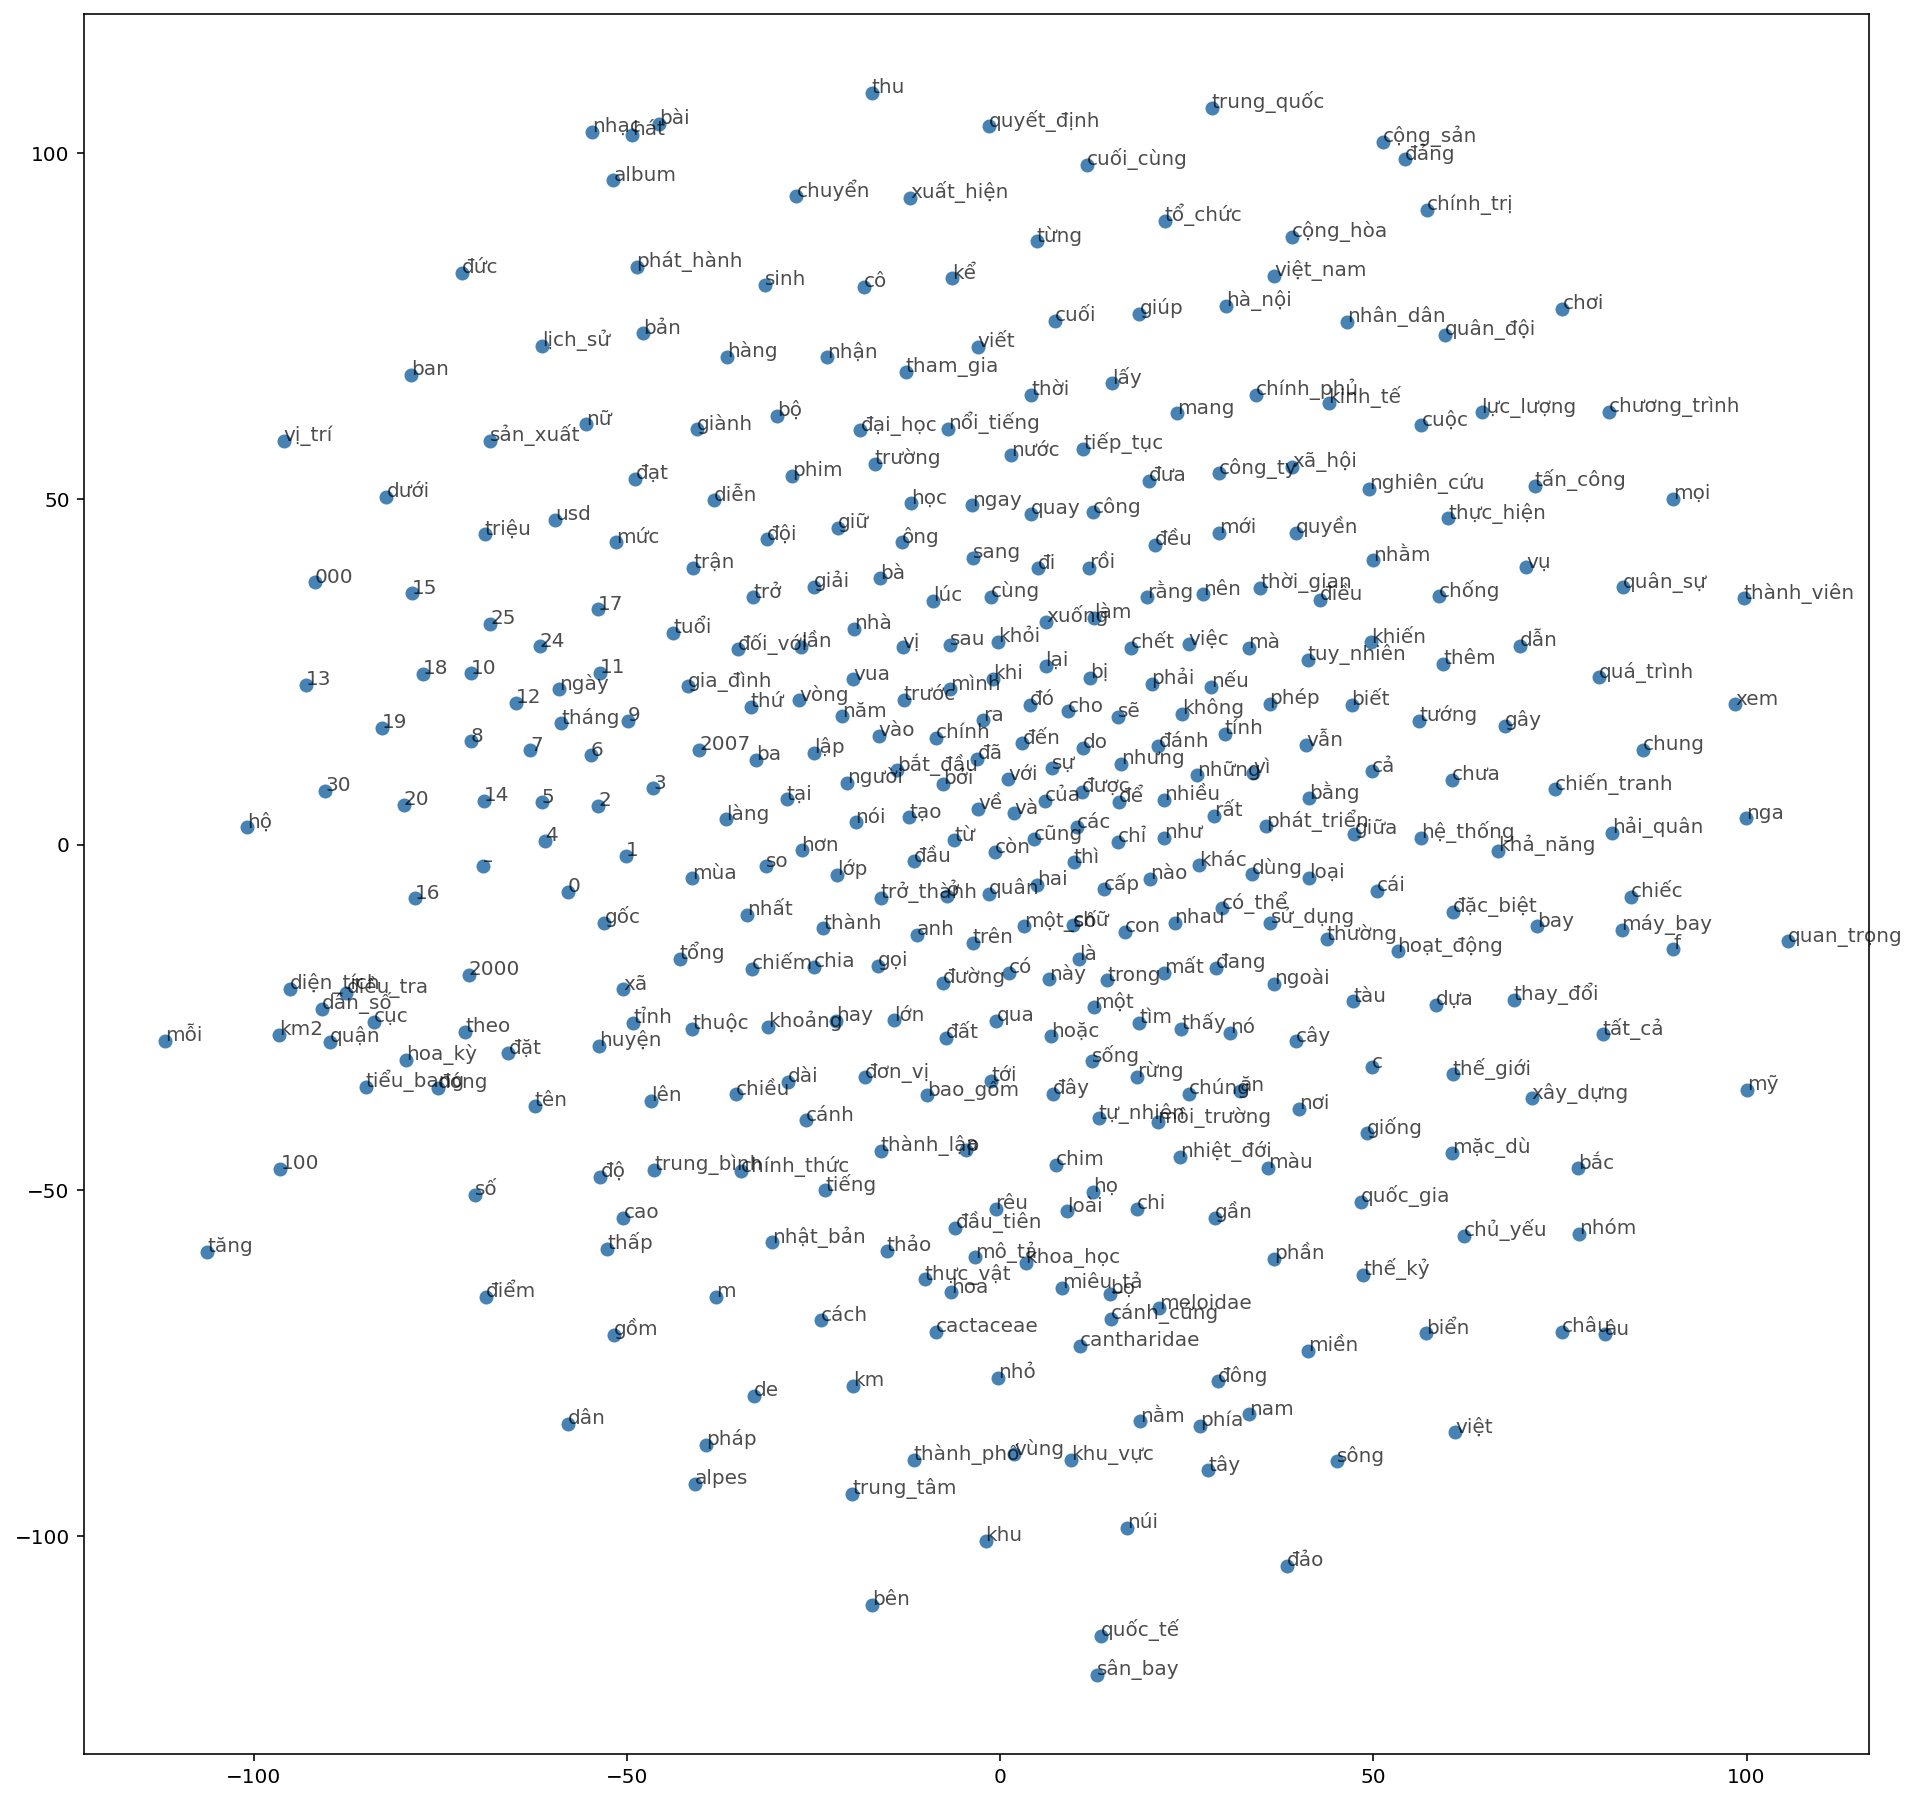

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
out_path = '/content/drive/MyDrive/Word2Vec_Vi/Model/Word2Vec_viwiki.bin'

In [ ]:
torch.save(model.state_dict(), out_path)

In [ ]:
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

(191067, 300)

In [ ]:
def get_top_similar(word: str, topN: int = 10):
    word_id = vocab_to_int[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = int_to_vocab[sim_word_id]
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [ ]:
get_top_similar('thủ_tướng')

{'chính_phủ': 0.38483673,
 'bầu_cử': 0.37743807,
 'cử_tri': 0.37617922,
 'nội_các': 0.37549722,
 'mahathir': 0.37465963,
 'đương_nhiệm': 0.37193197,
 'viên_chức': 0.36607814,
 'tổng_tuyển_cử': 0.3628431,
 'quốc_hội': 0.3618021,
 'tổng_bí_thư': 0.35662568}